# Question 2 - Assignment 2

The model is based on the AutoEncoder to use for the given set of images.

The code used PyTorch Deep Learning Framework and utilizes Binary Cross Entropy Function and Adam Optimizers with step-wise Learning-Rate Decay.

### Imports

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

### Variable Declaration

In [0]:
%matplotlib inline
batchSize = 32
imageSize = 128
learning_rate = 0.001
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
print(device)

### Load Dataset

#### Download and Organize Data

In [15]:
!wget https://cswww.essex.ac.uk/mv/allfaces/faces94.zip
!unzip faces94.zip
!mkdir data
!mv faces94/female/* data
!mv faces94/male/* data
!mv faces94/malestaff/* data
!rm faces94.zip
!rm -rf faces94
!ls data | wc -l

--2019-04-15 17:40:24--  https://cswww.essex.ac.uk/mv/allfaces/faces94.zip
Resolving cswww.essex.ac.uk (cswww.essex.ac.uk)... 155.245.92.179
Connecting to cswww.essex.ac.uk (cswww.essex.ac.uk)|155.245.92.179|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18845407 (18M) [application/zip]
Saving to: ‘faces94.zip’

faces94.zip         100%[===================>]  17.97M  71.3MB/s    in 0.3s    

2019-04-15 17:40:25 (71.3 MB/s) - ‘faces94.zip’ saved [18845407/18845407]

Archive:  faces94.zip
   creating: faces94/
   creating: faces94/female/
   creating: faces94/female/9336923/
  inflating: faces94/female/9336923/9336923.1.jpg  
  inflating: faces94/female/9336923/9336923.10.jpg  
  inflating: faces94/female/9336923/9336923.11.jpg  
  inflating: faces94/female/9336923/9336923.12.jpg  
  inflating: faces94/female/9336923/9336923.13.jpg  
  inflating: faces94/female/9336923/9336923.14.jpg  
  inflating: faces94/female/9336923/9336923.15.jpg  
  inflating: faces94/fe

#### DataLoader Declaration

In [35]:
def dataloader_function(datadir):
  
    data_transform = transforms.Compose([transforms.Resize((imageSize,imageSize)), transforms.ToTensor()])
    dataset = datasets.ImageFolder(datadir, transform = data_transform)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchSize, shuffle = True)
    
    return dataloader

data_dir = 'data/'
dataloader = dataloader_function(data_dir)
print(len(dataloader.dataset.classes))

153


### Model Definition

#### Weight Initialization

In [0]:
def weights_init(model):
    
    classname = model.__class__.__name__
    
    if classname.find('Conv') != -1:
        model.weight.data.normal_(0.0, 0.02)

#### Flatten Function

In [0]:
class Flatten(nn.Module):
    
    def forward(self, input):
        return input.view(input.size(0), -1)

#### Convolutional AutoEncoder

In [0]:
class ConvAutoencoder(nn.Module):
    
    def __init__(self, feature=False):
        
        super(ConvAutoencoder, self).__init__()
        self.feature = feature
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.linear = nn.Linear(128*8*8,100)
        self.t_conv1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.t_conv3 = nn.ConvTranspose2d(32, 16, 2, stride=2)
        self.t_conv4 = nn.ConvTranspose2d(16, 3, 2, stride=2)


    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        
        if self.feature:
          
          x = Flatten(x)
          return self.linear(x)
        
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        x = F.relu(self.t_conv3(x))
        x = F.sigmoid(self.t_conv4(x))
                
        return x

### Model Intialization

#### Model

In [0]:
net = ConvAutoencoder().to(device)
net.apply(init_weights)

#### Loss and Optimiser

In [0]:
criterion = nn.BCELoss()

optimizer = optim.Adam(net.parameters(), lr=learning_rate, betas=(0.2, 0.999))

scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5,10,15,20], gamma=0.1)

### Train the Model

In [0]:
losses = []

for epoch in range(25):
  
    scheduler.step()
  
    for i, data in enumerate(dataloader, 0):

        images = data[0].to(device)
        optimizer.zero_grad()
        outputs = net(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        
        print('[%d/%d][%d/%d]\tLoss: %.4f'
                  % (epoch, 25, i, len(dataloader),
                     loss.item()))
        
        losses.append(loss.item())

### Plot Graphs

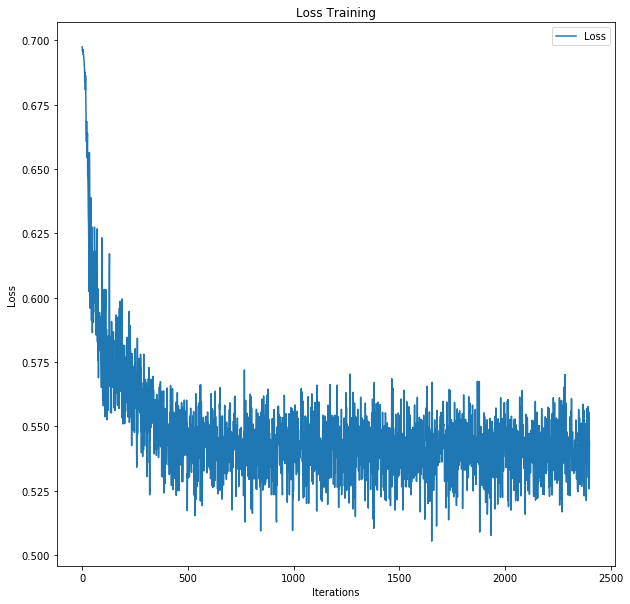

In [42]:
plt.figure(figsize=(10,10))
plt.title("Loss Training")
plt.plot(losses,label="Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig('graph.png')
plt.show()